# 导入模块

In [1]:
import json
import gzip
import numpy as np
import random
import paddle
import paddle.fluid as fluid
from paddle.fluid.dygraph import Linear
from paddle.fluid.dygraph.nn import Conv2D, Pool2D, Linear
import matplotlib.pyplot as plt

2020-08-19 14:26:24,734-INFO: generated new fontManager


# 准备数据

## 从飞桨读入数据集

In [2]:
# 如果～/.cache/paddle/dataset/mnist/目录下没有MNIST数据，API会自动将MINST数据下载到该文件夹下
# 设置数据读取器，读取MNIST数据训练集
trainset = paddle.dataset.mnist.train()
# 包装数据读取器，每次读取的数据数量设置为batch_size=100
train_reader = paddle.batch(trainset, batch_size=100)
# 将读入的数据打乱顺序
train_reader = fluid.io.shuffle(train_reader, 100)

Cache file /root/.cache/paddle/dataset/mnist/train-images-idx3-ubyte.gz not found, downloading https://dataset.bj.bcebos.com/mnist/train-images-idx3-ubyte.gz 
Begin to download

Download finished
Cache file /root/.cache/paddle/dataset/mnist/train-labels-idx1-ubyte.gz not found, downloading https://dataset.bj.bcebos.com/mnist/train-labels-idx1-ubyte.gz 
Begin to download
........
Download finished


## 将数据集从List类型转换为numpy数组

图像数据形状和对应数据为: (100, 1, 28, 28)
图像标签形状和对应数据为: (100, 1) [7.]


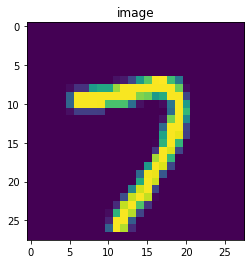

In [3]:
# 以迭代的形式读取数据
for batch_id, data in enumerate(train_reader()):
    # 获得图像数据，并转为float32类型的数组，遍历list，将每个元素从728转换为[1,28,28]，最后将list转换为array
    img_data = np.array([np.reshape(np.array(x[0]).astype('float32'), [1, 28, 28]) for x in data])
    # 获得图像标签数据，并转为float32类型的数组，将list转换为array并在后面添加一个维度
    label_data = np.array([x[1] for x in data]).astype('float32').reshape(-1, 1)
    # 打印数据形状
    print("图像数据形状和对应数据为:", img_data.shape)
#     print("图像数据形状和对应数据为:", img_data.shape, img_data[0])
    print("图像标签形状和对应数据为:", label_data.shape, label_data[0])
    break
# 显示第一batch的第一个图像
img = img_data[0][0]
plt.figure("Image")  # 图像窗口名称
plt.imshow(img)
plt.axis('on')  # 关掉坐标轴为 off
plt.title('image')  # 图像题目
plt.show()

# 定义网络

## 定义单层全连接网络

In [2]:
class MNIST(fluid.dygraph.Layer):
    def __init__(self):
        super(MNIST, self).__init__()
#         输入长度是28*28=784，输出则是判断的数字类别
        self.fc = Linear(input_dim=784, output_dim=1, act=None)

    def forward(self, inputs):
        inputs = fluid.layers.reshape(inputs, (-1, 784))
        outputs = self.fc(inputs)
        return outputs

## 定义多层全连接网络

In [17]:
class MNIST(fluid.dygraph.Layer):
    def __init__(self):
        super(MNIST, self).__init__()
        # 定义两层全连接隐含层，输出维度是10，激活函数为sigmoid
        self.fc1 = Linear(input_dim=784, output_dim=10, act='sigmoid') # 隐含层节点为10，可根据任务调整
        self.fc2 = Linear(input_dim=10, output_dim=10, act='sigmoid')
        # 定义一层全连接输出层，输出维度是1，不使用激活函数
        self.fc3 = Linear(input_dim=10, output_dim=1, act=None)
    
    # 定义网络的前向计算
    def forward(self, inputs, label=None):
        inputs = fluid.layers.reshape(inputs, [inputs.shape[0], 784])
        outputs1 = self.fc1(inputs)
        outputs2 = self.fc2(outputs1)
        outputs_final = self.fc3(outputs2)
        return outputs_final

## 多层卷积神经网络实现

In [4]:
# 多层卷积神经网络实现
class MNIST(fluid.dygraph.Layer):
     def __init__(self):
         super(MNIST, self).__init__()
         
         # 定义卷积层，输出特征通道num_filters设置为20，卷积核的大小filter_size为5，卷积步长stride=1，padding=2
         # 激活函数使用relu
         self.conv1 = Conv2D(num_channels=1, num_filters=20, filter_size=5, stride=1, padding=2, act='relu')
         # 定义池化层，池化核pool_size=2，池化步长为2，选择最大池化方式
         self.pool1 = Pool2D(pool_size=2, pool_stride=2, pool_type='max')
         # 定义卷积层，输出特征通道num_filters设置为20，卷积核的大小filter_size为5，卷积步长stride=1，padding=2
         self.conv2 = Conv2D(num_channels=20, num_filters=20, filter_size=5, stride=1, padding=2, act='relu')
         # 定义池化层，池化核pool_size=2，池化步长为2，选择最大池化方式
         self.pool2 = Pool2D(pool_size=2, pool_stride=2, pool_type='max')
         # 定义一层全连接层，输出维度是1，不使用激活函数
         self.fc = Linear(input_dim=980, output_dim=1, act=None)
         
    # 定义网络前向计算过程，卷积后紧接着使用池化层，最后使用全连接层计算最终输出
     def forward(self, inputs):
         x = self.conv1(inputs)
         x = self.pool1(x)
         x = self.conv2(x)
         x = self.pool2(x)
         x = fluid.layers.reshape(x, [x.shape[0], -1])
         x = self.fc(x)
         return x

# 训练网络，并保存模型

In [5]:
# 读取数据集数据，并乱序后放入模型进行训练
trainset = paddle.dataset.mnist.train()
train_reader = paddle.batch(trainset, batch_size=100)
train_reader = fluid.io.shuffle(train_reader, 100)

use_gpu = False # 如果使用Gpu进行训练则修改为True
place = fluid.CUDAPlace(0) if use_gpu else fluid.CPUPlace()
with fluid.dygraph.guard(place):
    model = MNIST()
    model.train()

    # 四种优化算法的设置方案，可以逐一尝试效果
    optimizer = fluid.optimizer.SGDOptimizer(learning_rate=0.001, parameter_list=model.parameters())
    # optimizer = fluid.optimizer.MomentumOptimizer(learning_rate=0.01, momentum=0.9, parameter_list=model.parameters())
    # optimizer = fluid.optimizer.AdagradOptimizer(learning_rate=0.01, parameter_list=model.parameters())
    # optimizer = fluid.optimizer.AdamOptimizer(learning_rate=0.01, parameter_list=model.parameters())

    EPOCH_NUM = 10
    for epoch_id in range(EPOCH_NUM):
        for batch_id, data in enumerate(train_reader()):
            # 获得图像数据，并转为float32类型的数组，遍历list，将每个元素从728转换为[1,28,28]，最后将list转换为array
            image_data = np.array([np.reshape(np.array(x[0]).astype('float32'), [1, 28, 28]) for x in data])
            # 获得图像标签数据，并转为float32类型的数组，将list转换为array并在后面添加一个维度
            label_data = np.array([x[1] for x in data]).astype('float32').reshape(-1, 1)
            # print(image_data.shape)
            image = fluid.dygraph.to_variable(image_data)
            label = fluid.dygraph.to_variable(label_data)

            # 前向计算的过程
            predict = model(image)

            # 计算损失，取一个批次样本损失的平均值
            loss = fluid.layers.square_error_cost(predict, label)
            avg_loss = fluid.layers.mean(loss)

            # 计算损失，使用交叉熵损失函数，取一个批次样本损失的平均值
#             loss = fluid.layers.cross_entropy(predict, label)
#             avg_loss = fluid.layers.mean(loss)

            # 每训练了200批次的数据，打印下当前Loss的情况
            if batch_id % 200 == 0:
                print("epoch: {}, batch: {}, loss is: {}".format(epoch_id, batch_id, avg_loss.numpy()))

            # 后向传播，更新参数的过程
            avg_loss.backward()
            optimizer.minimize(avg_loss)
            model.clear_gradients()

    # 保存模型参数
    fluid.save_dygraph(model.state_dict(), 'mnist')

epoch: 0, batch: 0, loss is: [17.600958]
epoch: 0, batch: 200, loss is: [2.51957]
epoch: 0, batch: 400, loss is: [1.8720033]
epoch: 1, batch: 0, loss is: [1.5634558]
epoch: 1, batch: 200, loss is: [1.6354859]
epoch: 1, batch: 400, loss is: [1.7413342]
epoch: 2, batch: 0, loss is: [1.1738201]
epoch: 2, batch: 200, loss is: [1.5190034]
epoch: 2, batch: 400, loss is: [2.9117508]
epoch: 3, batch: 0, loss is: [1.3247323]
epoch: 3, batch: 200, loss is: [1.2803106]
epoch: 3, batch: 400, loss is: [2.7125998]
epoch: 4, batch: 0, loss is: [1.1603993]
epoch: 4, batch: 200, loss is: [1.525015]
epoch: 4, batch: 400, loss is: [1.3977467]
epoch: 5, batch: 0, loss is: [1.1423038]
epoch: 5, batch: 200, loss is: [1.0669457]
epoch: 5, batch: 400, loss is: [1.347811]
epoch: 6, batch: 0, loss is: [0.9278978]
epoch: 6, batch: 200, loss is: [1.9005439]
epoch: 6, batch: 400, loss is: [1.430917]
epoch: 7, batch: 0, loss is: [1.4109778]
epoch: 7, batch: 200, loss is: [1.5345002]
epoch: 7, batch: 400, loss is: [

In [6]:
# 查看保存的模型的属性
print(model.parameters())

[name conv2d_0.w_0, dtype: VarType.FP32 shape: [20, 1, 5, 5] 	lod: {}
	dim: 20, 1, 5, 5
	layout: NCHW
	dtype: float
	data: [-0.227246 0.0548281 0.251354 -0.0798577 0.306433 -0.0788795 -0.0172948 0.762193 0.483228 -0.15396 0.0135982 0.0169954 -0.253063 -0.330747 -0.249401 0.247155 -0.153549 -0.115179 0.0774885 0.0665917 -0.37785 0.423157 -0.217491 -0.450712 -0.0188339 -0.0230892 -0.538814 -0.178613 0.328706 0.387427 -0.423183 0.323581 0.206155 -0.04375 -0.10055 0.765898 0.264762 0.109597 0.0377134 -0.0279006 0.248949 0.176892 -0.126463 -0.35219 -0.288167 -0.239866 -0.509895 0.22303 0.13139 0.306384 -0.106253 -0.0144631 0.474492 -0.406996 -0.0548578 -0.243999 -0.614443 0.23912 -0.0840249 0.300494 -0.336129 0.104439 -0.123694 -0.0852219 -0.316131 0.286032 0.152325 0.275713 -0.0192928 -0.00882145 0.0805475 0.185121 -0.031738 0.385909 -0.0583669 -0.370359 0.0306013 0.169645 -0.124752 -0.0764654 0.27568 0.107534 0.426383 0.411237 -0.310461 0.558313 -0.246247 0.104172 0.231704 0.547704 0.1391

# 测试模型

## 读入一张图片进行测试

In [7]:
# 读入测试集，并将测试集也乱序
testset = paddle.dataset.mnist.test()
test_reader = paddle.batch(testset, batch_size=100)
test_reader = fluid.io.shuffle(test_reader, 100)

Cache file /root/.cache/paddle/dataset/mnist/t10k-images-idx3-ubyte.gz not found, downloading https://dataset.bj.bcebos.com/mnist/t10k-images-idx3-ubyte.gz 
Begin to download

Download finished
Cache file /root/.cache/paddle/dataset/mnist/t10k-labels-idx1-ubyte.gz not found, downloading https://dataset.bj.bcebos.com/mnist/t10k-labels-idx1-ubyte.gz 
Begin to download
..
Download finished


图像数据形状和对应数据为: (100, 1, 28, 28)
图像标签形状和对应数据为: (100, 1) [8.]
[8.]


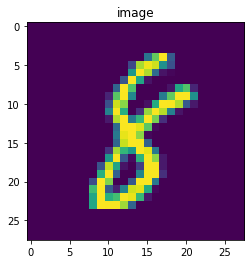

In [8]:
# 以迭代的形式读取数据
for batch_id, data in enumerate(test_reader()):
    # 获得图像数据，并转为float32类型的数组，遍历list，将每个元素从728转换为[1,28,28]，最后将list转换为array
    img_data = np.array([np.reshape(np.array(x[0]).astype('float32'), [1, 28, 28]) for x in data])
    # 获得图像标签数据，并转为float32类型的数组，将list转换为array并在后面添加一个维度
    label_data = np.array([x[1] for x in data]).astype('float32').reshape(-1, 1)
    break
# 打印数据形状
print("图像数据形状和对应数据为:", img_data.shape)
print("图像标签形状和对应数据为:", label_data.shape, label_data[0])
# 显示第一batch的第一个图像
img = img_data[0][0]
label = label_data[0]
print(label)
plt.figure("Image")  # 图像窗口名称
plt.imshow(img)
plt.axis('on')  # 关掉坐标轴为 off
plt.title('image')  # 图像题目
plt.show()

In [9]:
with fluid.dygraph.guard():
    model = MNIST()
    params_file_path = 'mnist'
    # 加载模型参数
    model_dict, _ = fluid.load_dygraph('mnist')
    model.load_dict(model_dict)
    # 灌入数据进行测试
    model.eval()
    img = img.reshape(1, 1, 28, 28)  # 将图片数据维度调整为[1,1,28,28]
    print(img.shape)
    result = model(fluid.dygraph.to_variable(img))
    print('本次预测是数字是：', result.numpy().astype('int32'))

(1, 1, 28, 28)
本次预测是数字是： [[8]]


需要注意的是，只有多层卷积神经网络识别的准确率高，单层全连接网络和多层全连接网络效果都不怎么样

## 读入100张图片，测试模型准确率

In [10]:
# 读入测试集，并将测试集也乱序
testset = paddle.dataset.mnist.test()
test_reader = paddle.batch(testset, batch_size=100)
test_reader = fluid.io.shuffle(test_reader, 100)

In [11]:
with fluid.dygraph.guard():
    print('start evaluation .......')
    # 加载模型参数
    model = MNIST()
    model_state_dict, _ = fluid.load_dygraph('mnist')
    model.load_dict(model_state_dict)

    model.eval()

    avg_loss_set = []
#     avg_acc_set = []
    for batch_id, data in enumerate(test_reader()):
        # 获得图像数据，并转为float32类型的数组，遍历list，将每个元素从728转换为[1,28,28]，最后将list转换为array
        img_data = np.array([np.reshape(np.array(x[0]).astype('float32'), [1, 28, 28]) for x in data])
        # 获得图像标签数据，并转为float32类型的数组，将list转换为array并在后面添加一个维度
        label_data = np.array([x[1] for x in data]).astype('float32').reshape(-1, 1)
        
        img = fluid.dygraph.to_variable(img_data)
        label = fluid.dygraph.to_variable(label_data)
        # print(img.shape,label.shape)
        prediction = model(img)
        loss = fluid.layers.square_error_cost(prediction, label)
#         print(type(prediction),type(label),type(loss))
#         print(prediction, fluid.dygraph.to_variable(label_data.astype('int64')))
#         acc = fluid.layers.accuracy(input=prediction, label=fluid.dygraph.to_variable(label_data.astype('int64')))
        avg_loss = fluid.layers.mean(loss)
        avg_loss_set.append(float(avg_loss.numpy()))
#         avg_acc = fluid.layers.mean(acc)
#         avg_acc_set.append(float(avg_acc.numpy()))

    # 计算多个batch的平均损失和准确率
    avg_loss_val_mean = np.array(avg_loss_set).mean()
#     avg_acc_val_mean = np.array(avg_acc_set).mean()

#     print('loss={},acc={}'.format(avg_loss_val_mean, avg_acc_val_mean))
    print('loss={}'.format(avg_loss_val_mean))

start evaluation .......
loss=1.1355495101213455
